# 05 - Taming Text

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words
from  email.parser import FeedParser
%matplotlib inline

## Part 1: Word cloud

### Email corpus extraction

As we are not intersted in every details (like the sender/receiver, etc..) our first task is to extract the body of the emails.

First let's read the Emails.csv file

In [173]:
mails = pd.read_csv("hillary-clinton-emails/Emails.csv")

In [174]:
mails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


Now we have two options: take the raw text or use the extracted body, but since the content of the raw text seems to be messy (further inspections confirmed this) and as some people already did the work for us, we are going to use the extracted bodies.

In [175]:
emailsBody = mails['ExtractedBodyText'].dropna()
print(len(emailsBody))
emailsBody.head()

6742


1    B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...
2                                                  Thx
4    H <hrod17@clintonemail.com>\nFriday, March 11,...
5    Pis print.\n-•-...-^\nH < hrod17@clintonernail...
7    H <hrod17@clintonemail.corn>\nFriday, March 11...
Name: ExtractedBodyText, dtype: object

We then lower case everything (no important information is lost with this and it may avoid us troubles, plus better uniformity)

In [176]:
emailsBody = emailsBody.apply(lambda x: x.lower())

We need the data to be represented in a single string, so we first merge all the cells in a single array and then merge that array in a single string

In [177]:
textArray = emailsBody.values.flatten()
textString = ' '.join(textArray)

The first method is straightforward, generate a cloud directly from the unprocessed, untokenized string

In [178]:
cloud = WordCloud().generate(textString)
#cloud = WordCloud(max_font_size=40).generate(rawTextString) limits size of biggest word

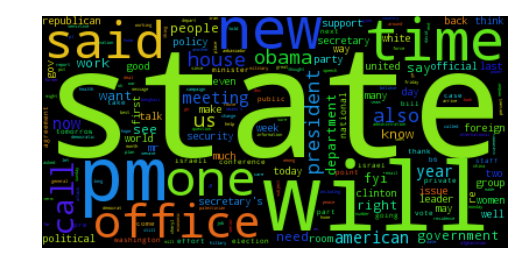

In [179]:
plt.imshow(cloud)
plt.axis('off')
plt.show()

This word cloud shows what we could expect from such emails (state, office, Obama, ...) but also a lot of noisy words that do not give relevant informations, such as 'will', 'said', 'call', etc.. The next steps are intended to improve the cloud.

### Tokenization & stop words

We will now tokenize the entire string, Regexp does the big of the tokenization, while "stop_words" will get rid of useless words like "the", "and"... We also remove some useless dominant word we identified in the previous cloud.

In [180]:
#tokens = nltk.word_tokenize(rawTextString)
tokens = nltk.word_tokenize(rawTextString)
tokenizer = RegexpTokenizer(r'\w+')
allTokens = pd.Series(tokenizer.tokenize(textString))
allTokens = allTokens[~allTokens.isin({'will', 'pm', 'said', 'call'})]
print("Number of tokens: ", len(allTokens))

Number of tokens:  619194


In [181]:
en_stop = get_stop_words('en')
stopTokens = allTokens[~allTokens.isin(en_stop)]
print("Number of tokens after stop word filtering: ", len(stopTokens))

Number of tokens after stop word filtering:  375341


In [182]:
print("Remaining tokens: ", round(len(stopTokens) / len(allTokens) * 100), "%")

Remaining tokens:  61 %


The stop words filtering got rid of 39% of the tokens, which is quite big.

Now that nltk got rid of unecessary data for us, we'll merge the array back into a string and use wordcloud again

In [183]:
cleanString = ' '.join(allTokens)

In [184]:
cleanCloud = WordCloud().generate(cleanString)

Raw


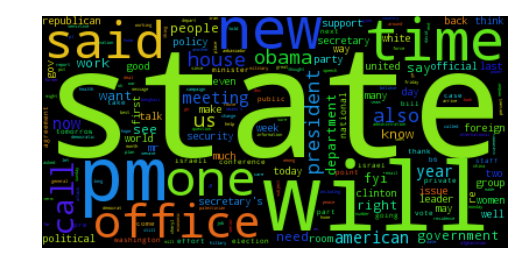

Without stopwords


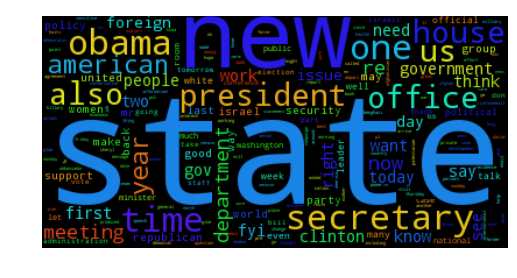

In [185]:
print("Raw")
plt.imshow(cloud)
plt.axis('off')
plt.show()
print("Without stopwords")
plt.imshow(cleanCloud)
plt.axis('off')
plt.show()

It is indeed better, the removal of some dominant words allowed more relevant ones to appear, and it looks pretty nice.

### Stemming

The next processing step is stemming, for this purpose we are going to use Porter's algorithm, which is already implemented in the stemming python library.

In [186]:
stemmer = PorterStemmer()

In [187]:
stemTokens = stopTokens.apply(stemmer.stem)

In [188]:
tokens = stemTokens #for next part

In [189]:
stopStemStr = ' '.join(stemTokens)
stemCloud = WordCloud().generate(stopStemStr)

Without stopwords


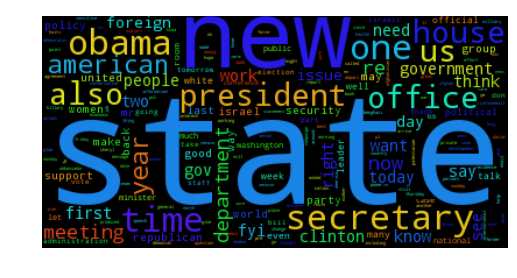

Without stopwords + stemming


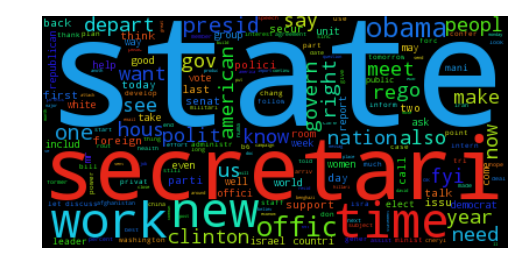

In [190]:
print("Without stopwords")
plt.imshow(cleanCloud)
plt.axis('off')
plt.show()
print("Without stopwords + stemming")
plt.imshow(stemCloud)
plt.axis('off')
plt.show()

The result here is a bit different, the stemming transformed some of the words, but now we have a more accurate representation of the kind of vocabulary used in these emails. For example, 'work' was not even there in the previous cloud and some irrelevant words lost of their weight like 'also', 'one', 'us', ...

## PART 2

First we are going to create an empty dictionary

In [50]:
import pycountry
import re
import numpy as np
from nltk.sentiment.vader import *
sentiment = {}

Then we get the Extracted Body Text from the emails and store them in a separate dataframe. After that we remove the end line chars.

In [51]:
mails_clean = mails.dropna(axis=0, subset=["ExtractedBodyText"])
body_texts = mails_clean["ExtractedBodyText"]
for i in range(len(body_texts.values)):
    body_texts.values[i] = body_texts.values[i].replace("\n", " ")

We will now analyze all emails and store the score in an array. We do this because sometimes more than one county can be mentioned in an email and we don't want to analyze the same email twice.

In [52]:
analyzer = nltk.sentiment.vader.SentimentIntensityAnalyzer()
email_vader_val = []
for i in range(len(body_texts.values)):
    email_vader_val.append(analyzer.polarity_scores(body_texts.values[i])["compound"])

Now we will iterate over all countires and if we find a mention of a country in a email we add the score of that email to an array for that country. At the end we average out the score of all emails for the specific country. We also added a minimum number of emails in this case 15 to reduce the number of countires for the plot, but this is optional and can be set to 1.

In [93]:
for country in pycountry.countries:
    country_arr = []
    for i in range(len(body_texts.values)):
        name = r'\b' + country.name + r'\b'
        if re.search(name, body_texts.values[i], re.IGNORECASE):
            country_arr.append(email_vader_val[i])
            continue
        alpha_2 = r'\b' + country.alpha_2 + r'\b'
        if re.search(alpha_2, body_texts.values[i]):
            country_arr.append(email_vader_val[i])
            continue
        alpha_3 = r'\b' + country.alpha_3 + r'\b'
        if re.search(alpha_3, body_texts.values[i]):
            country_arr.append(email_vader_val[i])
            continue
        if hasattr(country, 'official_name'):
            official_name = r'\b' + country.official_name + r'\b'
            if re.search(official_name, body_texts.values[i], re.IGNORECASE):
                country_arr.append(email_vader_val[i])
                continue
    if  len(country_arr) > 15:
        sentiment[country.name] = np.average(country_arr) 

Finaly we generate a colour range and then we plot the sorted values

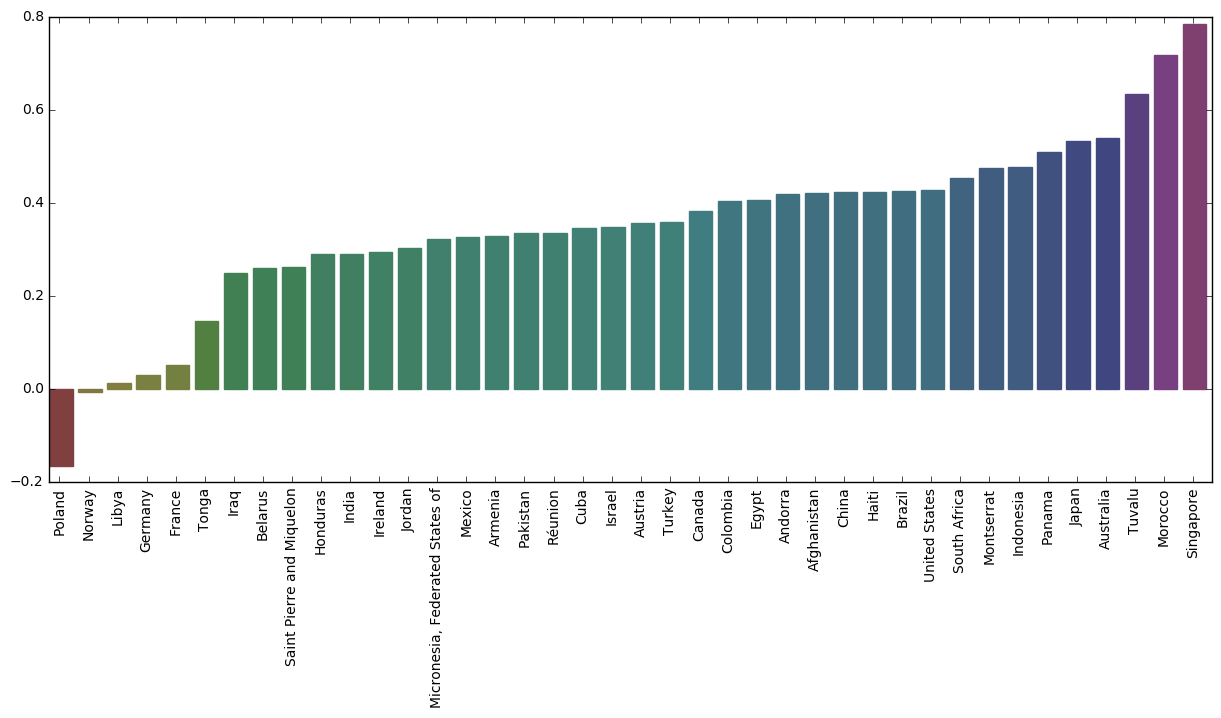

In [98]:
import colorsys
from skipdict import SkipDict
color_vals = np.array(sorted(sentiment.values()))
color_vals = (color_vals - np.min(color_vals))/(2*np.max(color_vals) - np.min(color_vals))
RGB_tuples = [colorsys.hsv_to_rgb(x*1.6, 0.5, 0.5) for x in color_vals]

ind = np.arange(len(sentiment.values()))               
width = 0.35 

fig = plt.figure(figsize=(15, 6))
hist_plot = fig.add_subplot(111)
hp = hist_plot.bar(range(len(sentiment)), sorted(sentiment.values()))
for i in range(len(RGB_tuples)):
    hp[i].set_color(RGB_tuples[i])
    
    
sortedSentimet = SkipDict(sentiment)   
xTickMarks = [str(key) for key in sortedSentimet.keys()]
hist_plot.set_xticks(ind+width)
xtickNames = hist_plot.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=90, fontsize=10)
plt.width 
plt.show()

Now let's create a new dict and in this one we are going to use the demo_liu_hu_lexicon function

In [145]:
sentiment_liu_hu = {}

We will now define a function to capture the output of demo_liu_hu_lexicon

In [42]:
from io import StringIO
import sys

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

We again analyze all emails and store the captured outputs in email_liu_hu_val

In [160]:
with Capturing() as  email_liu_hu_val:
    for i in range(0, 3984):
        nltk.sentiment.util.demo_liu_hu_lexicon(body_texts.values[i])

In [164]:
len(email_liu_hu_val)

6742

We need to convert the sting outputs to numbers

In [165]:
for i in range(len(email_liu_hu_val)):
    if email_liu_hu_val[i] == "Neutral":
        email_liu_hu_val[i] = 0
    elif email_liu_hu_val[i] == "Negative":
        email_liu_hu_val[i] = -1
    else:
        email_liu_hu_val[i] = 1

In [166]:
for country in pycountry.countries:
    country_arr = []
    for i in range(len(body_texts.values)):
        name = r'\b' + country.name + r'\b'
        if re.search(name, body_texts.values[i], re.IGNORECASE):
            country_arr.append(email_liu_hu_val[i])
            continue
        alpha_2 = r'\b' + country.alpha_2 + r'\b'
        if re.search(alpha_2, body_texts.values[i]):
            country_arr.append(email_liu_hu_val[i])
            continue
        alpha_3 = r'\b' + country.alpha_3 + r'\b'
        if re.search(alpha_3, body_texts.values[i]):
            country_arr.append(email_liu_hu_val[i])
            continue
        if hasattr(country, 'official_name'):
            official_name = r'\b' + country.official_name + r'\b'
            if re.search(official_name, body_texts.values[i], re.IGNORECASE):
                country_arr.append(email_liu_hu_val[i])
                continue
    if  len(country_arr) > 15:
        sentiment_liu_hu[country.name] = np.average(country_arr) 

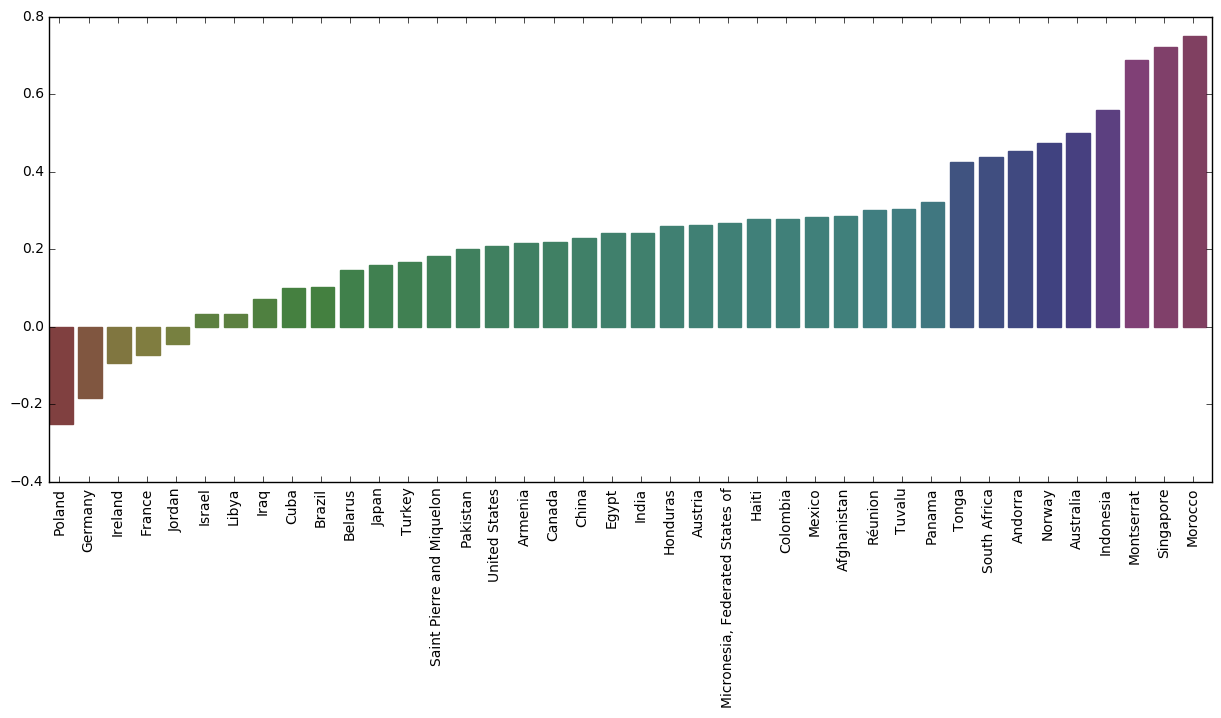

In [167]:
color_vals = np.array(sorted(sentiment_liu_hu.values()))
color_vals = (color_vals - np.min(color_vals))/(2*np.max(color_vals) - np.min(color_vals))
RGB_tuples = [colorsys.hsv_to_rgb(x*1.6, 0.5, 0.5) for x in color_vals]

ind = np.arange(len(sentiment_liu_hu.values()))               
width = 0.35 

fig = plt.figure(figsize=(15, 6))
hist_plot = fig.add_subplot(111)
hp = hist_plot.bar(range(len(sentiment_liu_hu)), sorted(sentiment_liu_hu.values()))
for i in range(len(RGB_tuples)):
    hp[i].set_color(RGB_tuples[i])
    
    
sortedSentimet_liu_hu = SkipDict(sentiment_liu_hu)   
xTickMarks = [str(key) for key in sortedSentimet_liu_hu.keys()]
hist_plot.set_xticks(ind+width)
xtickNames = hist_plot.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=90, fontsize=10)
plt.width 
plt.show()

In general we can see that the results at both ends are similar but there is some reordering in the mid part

## Part 3: Topic modeling

In [170]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

The dictionary function will assign and ID to each token and do word counting.
doc2bow converts a dictionary into a (word_id, word_frequency) tuple

In [191]:
dictionary = Dictionary([tokens]) #document term matrix
corpus = [dictionary.doc2bow(text) for text in [tokens]] #bag of words

We will now use the lda function from 5 to 50, printing the topic at each step

In [192]:
lda = [None]*45
for topics in range(5,50):
    idx = topics - 5
    lda[idx] = LdaModel(corpus, num_topics=topics, id2word = dictionary)

In [193]:
for i in range(0, len(lda)):
    print(lda[idx].print_topics(num_topics=3, num_words=3))

[(34, '0.014*"s" + 0.008*"state" + 0.004*"time"'), (10, '0.015*"s" + 0.007*"state" + 0.004*"obama"'), (4, '0.020*"s" + 0.010*"state" + 0.005*"can"')]
[(24, '0.016*"s" + 0.008*"state" + 0.005*"can"'), (23, '0.018*"s" + 0.007*"state" + 0.004*"time"'), (43, '0.016*"s" + 0.008*"state" + 0.005*"t"')]
[(15, '0.021*"s" + 0.006*"state" + 0.004*"1"'), (4, '0.020*"s" + 0.010*"state" + 0.005*"can"'), (11, '0.017*"s" + 0.007*"state" + 0.004*"can"')]
[(9, '0.017*"s" + 0.007*"state" + 0.005*"1"'), (6, '0.021*"s" + 0.007*"state" + 0.005*"t"'), (5, '0.019*"s" + 0.010*"state" + 0.004*"t"')]
[(6, '0.021*"s" + 0.007*"state" + 0.005*"t"'), (3, '0.017*"s" + 0.008*"state" + 0.004*"can"'), (14, '0.019*"s" + 0.007*"state" + 0.005*"can"')]
[(44, '0.015*"s" + 0.009*"state" + 0.005*"u"'), (43, '0.016*"s" + 0.008*"state" + 0.005*"t"'), (1, '0.020*"s" + 0.008*"state" + 0.004*"t"')]
[(19, '0.023*"s" + 0.009*"state" + 0.005*"can"'), (27, '0.025*"s" + 0.009*"state" + 0.005*"t"'), (48, '0.014*"s" + 0.009*"state" + 0.0

Now that the algorithm generated all the possibilities for each parameter, we observe that a lot of topics contain a single letter (which is due to the previous processing), let's try to redo it but without these noise letters.

In [194]:
tokens2 = tokens[~tokens.isin(['s', 't'])]
len(tokens) - len(tokens2)

9061

In [195]:
dictionary = Dictionary([tokens2]) #document term matrix
corpus = [dictionary.doc2bow(text) for text in [tokens2]] #bag of words

In [196]:
lda2 = [None] * 45
for topics in range(5,50):
    idx = topics - 5
    lda2[idx] = LdaModel(corpus, num_topics=topics, id2word = dictionary)

In [197]:
for i in range(0, len(lda2)):
    print(lda2[idx].print_topics(num_topics=3, num_words=3))

[(44, '0.008*"state" + 0.004*"u" + 0.004*"depart"'), (39, '0.007*"state" + 0.004*"work" + 0.004*"can"'), (43, '0.007*"state" + 0.004*"can" + 0.004*"1"')]
[(12, '0.008*"state" + 0.005*"can" + 0.004*"obama"'), (44, '0.008*"state" + 0.004*"u" + 0.004*"depart"'), (46, '0.009*"state" + 0.007*"can" + 0.005*"meet"')]
[(6, '0.008*"state" + 0.005*"can" + 0.004*"offic"'), (28, '0.008*"state" + 0.006*"time" + 0.005*"u"'), (40, '0.008*"state" + 0.005*"can" + 0.005*"secretari"')]
[(29, '0.009*"state" + 0.005*"can" + 0.004*"work"'), (20, '0.010*"state" + 0.004*"time" + 0.004*"u"'), (2, '0.009*"state" + 0.004*"1" + 0.004*"obama"')]
[(22, '0.009*"state" + 0.004*"one" + 0.004*"work"'), (43, '0.007*"state" + 0.004*"can" + 0.004*"1"'), (40, '0.008*"state" + 0.005*"can" + 0.005*"secretari"')]
[(15, '0.009*"state" + 0.005*"can" + 0.004*"new"'), (48, '0.007*"state" + 0.004*"can" + 0.003*"offic"'), (29, '0.009*"state" + 0.005*"can" + 0.004*"work"')]
[(15, '0.009*"state" + 0.005*"can" + 0.004*"new"'), (34, '0

This is better, the first thing we notice is that all topics contain the words 'state', and it definitely seems that even with 5 topics we have consistent words in them.

## Bonus

First let's drop all rows with missing information

In [198]:
mails_clean_people = mails.dropna(axis=0, subset=["ExtractedBodyText", "MetadataTo", "MetadataFrom"])
senders = mails_clean_people["MetadataFrom"]
recepients = mails_clean_people["MetadataTo"]
texts = mails_clean_people["ExtractedBodyText"]
senders.index = range(0, len(mails_clean_people))
recepients.index = range(0, len(mails_clean_people))
texts.index = range(0, len(mails_clean_people))

In [199]:
len(mails_clean_people)

6669

Now we will crate the graph and add and Edge for each email.

In [201]:
import networkx as nx
import community
G=nx.Graph()
for i in range(len(mails_clean_people)):
    G.add_edge(senders[i], recepients[i])

We now partition the grpah

In [202]:
partition = community.best_partition(G)

Finaly we crate a dict where we store all emails form a community 

In [235]:
emails_per_community = {}
for c in set(partition.values()):
    emails_per_community[c] = []
for i in range(len(mails_clean_people)):
    if partition[senders[i]] == partition[recepients[i]]:
        emails_per_community[partition[senders[i]]].append(texts[i].replace("\n", " "))
    else:
        emails_per_community[partition[senders[i]]].append(texts[i].replace("\n", " "))
        emails_per_community[partition[recepients[i]]].append(texts[i].replace("\n", " "))

In [236]:
for c in set(partition.values()):
    emails_per_community[c] =  ' '.join(emails_per_community[c])
    emails_per_community[c] = emails_per_community[c].lower()
    emails_per_community[c] = pd.Series(tokenizer.tokenize(emails_per_community[c]))
    emails_per_community[c] = emails_per_community[c][~emails_per_community[c].isin(en_stop)]
    D = Counter(emails_per_community[c])
    print(D.most_common(20))
    print("\n")

[('shift', 17), ('day', 14), ('work', 11), ('sleep', 10), ('lgf', 8), ('night', 7), ('time', 7), ('days', 6), ('convoy', 6), ('hours', 6), ('s', 6), ('deprivation', 5), ('schedule', 5), ('can', 5), ('average', 5), ('00hrs', 4), ('pattern', 4), ('3', 4), ('hour', 4), ('sleeping', 4)]


[('s', 6801), ('will', 2554), ('state', 2481), ('pm', 2044), ('t', 1522), ('can', 1482), ('secretary', 1292), ('1', 1276), ('said', 1183), ('u', 1160), ('obama', 1143), ('office', 1065), ('one', 1058), ('president', 1054), ('new', 1019), ('also', 934), ('time', 934), ('call', 934), ('house', 926), ('w', 923)]


[('s', 1765), ('will', 974), ('state', 917), ('u', 629), ('can', 458), ('said', 398), ('t', 390), ('call', 381), ('2015', 315), ('also', 309), ('just', 297), ('house', 285), ('one', 282), ('people', 277), ('pm', 271), ('president', 268), ('now', 266), ('department', 261), ('new', 260), ('us', 256)]


[('s', 1542), ('pm', 1494), ('state', 826), ('secretary', 825), ('office', 761), ('will', 583), ('3

It is interesing that some communites are small so the results form them are not very relevan, but it's interesing that you can notice some patterns it the larger gorups. For example in one group there is a lot of reference to Madam Secratary but in anohter group there is a lot of reference to President Obama